cropped_yale_SVM&KNN

## <center>Face Recognition<center>

The Extended Yale Facedatabase B contains 2414 images of 39 different people in its cropped version

try 3 different Face-recognition approaches: KNN, PCA, Convolutional Neural Network(CNN)
    
to check their advantages and disadvantages under different scenario

### <center> Pipeline and CV<center> 

#### <center>optimal gamma for rbf_SVM<center>

In [1]:
# gaussian_kernel sigma 
def optimal_sigma(x_train, y_train, size=100, K=7, dist_mat = True):
    import sklearn.neighbors as nbs
    
    #set up subset of training data by class
    x_train_class = []   
    #Setup sample data by class
    sample_x_class = []
    # Setup KDT tree subgroup
    ref_forest = []
    # get unique labels and counts of each label 
    unique, counts = np.unique(y_train, return_counts=True)
    nclass = len(unique)
    # matrix to store Kth nearest distance to each sample point in each class
    k_dist = np.zeros((size, nclass), dtype = 'float')
    # get sample size of each label based on its proportion of population
    np.random.seed(123)
    sample_size = (np.rint(counts * size / y_train.shape[0])).astype(int)
    
    for i in range(0, nclass):
        # get training points of label i
        x_train_l = x_train[y_train == unique[i]]
        # assign x_train by label into (0-9) subsets
        x_train_class.append(x_train_l)
        # range for sampling
        c = range(0, counts[i])
        # get index of random samples
        idx = np.random.choice(c, sample_size[i], replace = False)  # no repetitives in random samples
        # append random saples of label i to sample data list
        sample_x_class.append(x_train_l[idx])
        # append training data of label i to KDT list
        ref_forest.append(nbs.KDTree(x_train_class[i]))
        # get k nearest dist and their indices in training set of label i
        dist, ind = ref_forest[i].query(sample_x_class[i], k = K)
        # print(dist)
        for j in range(0, sample_size[i] ):   
            # ind[j,0:k]  gives index of kth nearest points from each sample point to all data in KDT
            # dist[j,0:k] gives dist  of kth nearest points from each sample point to all data in KDT
            loc = np.sum(sample_size[0:i])
            k_dist[j + loc , i] = dist[j, K-1]
        
    if dist_mat == True:
        return (k_dist, np.sum(k_dist) / np.sum(sample_size) )
    else: 
        return np.sum(k_dist) / np.sum(sample_size)

In [2]:
result = optimal_sigma(x_train_pca, y_train, size=800, K=7, dist_mat = True)

NameError: name 'x_train_pca' is not defined

In [37]:
optimal_sigma = result[1]
optimal_sigma

113.05562877427953

In [38]:
optimal_gamma = 1/(2*(optimal_sigma**2))
optimal_gamma

3.911880908825158e-05

### <center>GridSearch for kernel_SVM(chen's approach)<center>
<center>gaussian<center>

In [46]:
%time
pipe = Pipeline([
    ('reduce_dim', PCA(svd_solver='randomized',whiten=True)),
    ('classify', SVC(kernel='rbf', class_weight='balanced'))
])

N_FEATURES_OPTIONS = [200]
C_OPTIONS = [1e3, 5e3, 1e4, 5e4, 1e5]
gamma_OPTIONS = [optimal_gamma]
        
param_grid = [{
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS,
        'classify__gamma' : gamma_OPTIONS
    }]

grid = GridSearchCV(pipe, cv=3, n_jobs= -1,param_grid=param_grid)
grid = grid.fit(x_train, y_train)
print("Best estimator found by grid search:")
print(grid.best_estimator_)
print ('-----------------------------------------------------------------------')
print ('Best score found with the grid search (CV 3 folds)', grid.best_score_)
print ('-----------------------------------------------------------------------')

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 15 µs
Best estimator found by grid search:
Pipeline(memory=None,
     steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=True)), ('classify', SVC(C=10000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=3.911880908825158e-05,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])
-----------------------------------------------------------------------
Best score found with the grid search (CV 3 folds) 0.9847856154910097
-----------------------------------------------------------------------


In [43]:
import time

print("Predicting people's names on the test set")
t0 = time.time()
y_pred_rbf = grid.predict(x_test)
print("done in %0.3fs" % (time.time() - t0))

print(classification_report(y_test, y_pred_rbf))

Predicting people's names on the test set
done in 0.228s
             precision    recall  f1-score   support

         01       1.00      1.00      1.00         7
         02       1.00      1.00      1.00         4
         03       1.00      1.00      1.00         5
         04       1.00      1.00      1.00         5
         05       1.00      1.00      1.00        12
         06       1.00      1.00      1.00         6
         07       0.93      1.00      0.96        13
         08       1.00      1.00      1.00        10
         09       1.00      1.00      1.00         6
         10       1.00      1.00      1.00         6
         11       0.86      1.00      0.92         6
         12       1.00      1.00      1.00         6
         13       1.00      1.00      1.00         6
         15       1.00      1.00      1.00         7
         16       0.89      0.89      0.89         9
         17       1.00      1.00      1.00         3
         18       0.00      0.00      0.0

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### <center>GridSearch for kernel_SVM(chen's approach)<center>
<center>poly<center>

In [47]:
%time
pipe = Pipeline([
    ('reduce_dim', PCA(svd_solver='randomized',whiten=True)),
    ('classify', SVC(kernel='poly', class_weight='balanced'))
])

N_FEATURES_OPTIONS = [200]
C_OPTIONS = [1e3, 5e3, 1e4, 5e4, 1e5]
DEGREE_OPTIONS = [2,3]
        
param_grid = [{
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS,
        'classify__degree' : DEGREE_OPTIONS
    }]

grid = GridSearchCV(pipe, cv=3, n_jobs= -1,param_grid=param_grid)
grid = grid.fit(x_train, y_train)
print("Best estimator found by grid search:")
print(grid.best_estimator_)
print ('-----------------------------------------------------------------------')
print ('Best score found with the grid search (CV 3 folds)', grid.best_score_)
print ('-----------------------------------------------------------------------')

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 20 µs
Best estimator found by grid search:
Pipeline(memory=None,
     steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=True)), ('classify', SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
-----------------------------------------------------------------------
Best score found with the grid search (CV 3 folds) 0.966804979253112
-----------------------------------------------------------------------


In [48]:
import time

print("Predicting people's names on the test set")
t0 = time.time()
y_pred_poly = grid.predict(x_test)
print("done in %0.3fs" % (time.time() - t0))

print(classification_report(y_test, y_pred_poly))

Predicting people's names on the test set
done in 0.392s
             precision    recall  f1-score   support

         01       1.00      1.00      1.00         7
         02       1.00      1.00      1.00         4
         03       1.00      1.00      1.00         5
         04       1.00      1.00      1.00         5
         05       1.00      1.00      1.00        12
         06       1.00      1.00      1.00         6
         07       1.00      0.92      0.96        13
         08       1.00      1.00      1.00        10
         09       0.86      1.00      0.92         6
         10       0.86      1.00      0.92         6
         11       1.00      1.00      1.00         6
         12       1.00      1.00      1.00         6
         13       1.00      1.00      1.00         6
         15       1.00      1.00      1.00         7
         16       0.90      1.00      0.95         9
         17       1.00      1.00      1.00         3
         19       1.00      1.00      1.0

### <center>kernel_SVM<center>
<center>linear<center>

In [23]:
%time
pipe = Pipeline([
    ('classify', SVC(kernel='linear', class_weight='balanced'))
])
C_OPTIONS = [1e3, 5e3, 1e4, 5e4, 1e5]
        
param_grid = [{
        'classify__C': C_OPTIONS
    }]

grid = GridSearchCV(pipe, cv=3, n_jobs= -1,param_grid=param_grid)
grid = grid.fit(x_train_pca, y_train)
print("Best estimator found by grid search:")
print(grid.best_estimator_)
print ('-----------------------------------------------------------------------')
print ('Best score found with the grid search (CV 3 folds)', grid.best_score_)
print ('-----------------------------------------------------------------------')

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs
Best estimator found by grid search:
Pipeline(memory=None,
     steps=[('classify', SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
-----------------------------------------------------------------------
Best score found with the grid search (CV 3 folds) 0.9783310281235592
-----------------------------------------------------------------------


In [24]:
import time

print("Predicting people's names on the test set")
t0 = time.time()
y_pred_lin = grid.predict(x_test_pca)
print("done in %0.3fs" % (time.time() - t0))

print(classification_report(y_test, y_pred_lin))

Predicting people's names on the test set
done in 0.108s
             precision    recall  f1-score   support

         01       1.00      1.00      1.00         7
         02       1.00      1.00      1.00         4
         03       1.00      1.00      1.00         5
         04       1.00      1.00      1.00         5
         05       1.00      1.00      1.00        12
         06       1.00      1.00      1.00         6
         07       1.00      1.00      1.00        13
         08       1.00      1.00      1.00        10
         09       1.00      1.00      1.00         6
         10       1.00      1.00      1.00         6
         11       1.00      1.00      1.00         6
         12       1.00      1.00      1.00         6
         13       1.00      1.00      1.00         6
         15       1.00      1.00      1.00         7
         16       0.90      1.00      0.95         9
         17       0.75      1.00      0.86         3
         19       1.00      1.00      1.0

In [55]:
ovr_lin_accu = []
t0 = time.time()
for i in [1e3, 5e3, 1e4, 5e4, 1e5]:
    ovr_lin = SVC(kernel='linear', C = i,decision_function_shape='ovr')
    ovr_lin = ovr_lin.fit(x_train_pca,y_train)
    x_test_ovr_lin_pred = ovr_lin.predict(x_test_pca) #gives you the predicted label for test data
    scores = accuracy_score(y_test,x_test_ovr_lin_pred)
    ovr_lin_accu.append(scores)
time.time()-t0

4.490072965621948

In [56]:
ovr_lin_accu

[0.9875518672199171,
 0.9875518672199171,
 0.9875518672199171,
 0.9875518672199171,
 0.9875518672199171]

### <center>Plot<center>

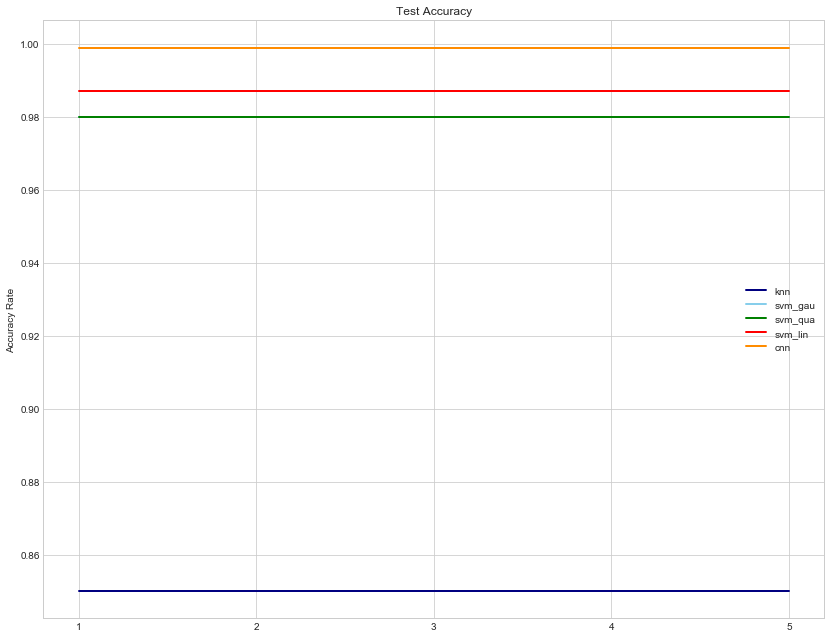

In [27]:
plt.rcParams['figure.figsize'] = [14,11]
cs = range(1,6)
plt.xticks(cs)


a = np.full((5,1),0.85)
b = np.full((5,1),0.98)
c = np.full((5,1),0.98)
d = np.full((5,1),0.987)
e = np.full((5,1),0.999)

# plot misclassification test error vs k
knn, = plt.plot(cs,a,color='navy', linestyle='solid', linewidth = 2,markersize=5)
gau, = plt.plot(cs,b,color='skyblue', linestyle='solid', linewidth = 2,markersize=5)
poly, = plt.plot(cs,c,color='green', linestyle='solid', linewidth = 2,markersize=5)
lin, = plt.plot(cs,d,color='red', linestyle='solid', linewidth = 2,markersize=5)
cnn, = plt.plot(cs,e,color='darkorange', linestyle='solid', linewidth = 2,markersize=5)


plt.title('Test Accuracy')
plt.xlabel('')
plt.ylabel('Accuracy Rate')


plt.legend([knn,gau,poly,lin,cnn],["knn","svm_gau","svm_qua","svm_lin","cnn"])
plt.show()